In [1]:
import tensorflow as tf

flags = tf.app.flags
logging = tf.logging

flags.DEFINE_string("model", "small", "A type of model. Possible options are: small, medium, large.")

tf.app.flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string("data_path", '/home/ubuntu/simple-examples/data',"Where the training/test data is stored.")
flags.DEFINE_string("save_path", '/home/ubuntu/simple-examples/data/lang_model.ckpt',
                    "Model output directory.")
flags.DEFINE_bool("use_fp16", False,
                  "Train using 16-bit floats instead of 32bit floats")
flags.DEFINE_integer("num_gpus", 0,
                     "If larger than 1, Grappler AutoParallel optimizer "
                     "will create multiple training replicas with each GPU "
                     "running one replica.")
flags.DEFINE_string("rnn_mode", None,
                    "The low level implementation of lstm cell: one of CUDNN, "
                    "BASIC, and BLOCK, representing cudnn_lstm, basic_lstm, "
                    "and lstm_block_cell classes.")
FLAGS = tf.app.flags.FLAGS
BASIC = "basic"
CUDNN = "cudnn"
BLOCK = "block"

In [26]:
"""Utilities for parsing PTB text files."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import sys

import tensorflow as tf

Py3 = sys.version_info[0] == 3

def _read_words(filename):
    with tf.gfile.GFile(filename, "r") as f:
        if Py3:
            return f.read().replace("\n", "<eos>").split()
        else:
            return f.read().decode("utf-8").replace("\n", "<eos>").split()


def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))

    # jwm: write out the vocabulary
    with open('/home/ubuntu/temp/vocab.txt', 'w') as f:
        for w in words:
            f.write(w + '\n')

    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]


def ptb_raw_data(data_path=None):
    """Load PTB raw data from data directory "data_path".
    Reads PTB text files, converts strings to integer ids,
    and performs mini-batching of the inputs.
    The PTB dataset comes from Tomas Mikolov's webpage:
    http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
    Args:
        data_path: string path to the directory where simple-examples.tgz has
            been extracted.
    Returns:
        tuple (train_data, valid_data, test_data, vocabulary)
        where each of the data objects can be passed to PTBIterator.
    """

    train_path = os.path.join(data_path, "ptb.train.txt")
    valid_path = os.path.join(data_path, "ptb.valid.txt")
    test_path = os.path.join(data_path, "ptb.test.txt")

    word_to_id = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)
    vocabulary = len(word_to_id)
    return train_data, valid_data, test_data, vocabulary


def ptb_producer(raw_data, batch_size, num_steps, name=None):
    """Iterate on the raw PTB data.
    This chunks up raw_data into batches of examples and returns Tensors that
    are drawn from these batches.
    Args:
        raw_data: one of the raw data outputs from ptb_raw_data.
        batch_size: int, the batch size.
        num_steps: int, the number of unrolls.
        name: the name of this operation (optional).
    Returns:
        A pair of Tensors, each shaped [batch_size, num_steps]. The second element
        of the tuple is the same data time-shifted to the right by one.
    Raises:
        tf.errors.InvalidArgumentError: if batch_size or num_steps are too high.
    """
    with tf.name_scope(name, "PTBProducer", [raw_data, batch_size, num_steps]):
        raw_data = tf.convert_to_tensor(raw_data, name="raw_data", dtype=tf.int32)
        print(raw_data) # 
        data_len = tf.size(raw_data)
        print(data_len)
        # jwm: num_batches would be a better name
        batch_len = data_len // batch_size
        print(batch_len)
        # jwm: data of form [batch_size x num_batches]
        data = tf.reshape(raw_data[0 : batch_size * batch_len],
                                            [batch_size, batch_len])
        print("Data form num_batches * batch_size", data)
        epoch_size = (batch_len - 1) // num_steps
        print(epoch_size)
        assertion = tf.assert_positive(
                epoch_size,
                message="epoch_size == 0, decrease batch_size or num_steps")
        with tf.control_dependencies([assertion]):
            epoch_size = tf.identity(epoch_size, name="epoch_size")

        # jwm: You get some number between 0 and num_batches
        i = tf.train.range_input_producer(epoch_size, shuffle=False).dequeue()
        x = tf.strided_slice(data, [0, i * num_steps],
                                                 [batch_size, (i + 1) * num_steps])
        x.set_shape([batch_size, num_steps])
        y = tf.strided_slice(data, [0, i * num_steps + 1],
                                                 [batch_size, (i + 1) * num_steps + 1])
        y.set_shape([batch_size, num_steps])
        return x, y

In [27]:
import reader
print(FLAGS.data_path)
raw_data = ptb_raw_data(FLAGS.data_path)
train_data, valid_data, test_data, _ = raw_data
train_data

/home/ubuntu/simple-examples/data


[9970,
 9971,
 9972,
 9974,
 9975,
 9976,
 9980,
 9981,
 9982,
 9983,
 9984,
 9986,
 9987,
 9988,
 9989,
 9991,
 9992,
 9993,
 9994,
 9995,
 9996,
 9997,
 9998,
 9999,
 2,
 9256,
 1,
 3,
 72,
 393,
 33,
 2133,
 0,
 146,
 19,
 6,
 9207,
 276,
 407,
 3,
 2,
 23,
 1,
 13,
 141,
 4,
 1,
 5465,
 0,
 3081,
 1596,
 96,
 2,
 7682,
 1,
 3,
 72,
 393,
 8,
 337,
 141,
 4,
 2477,
 657,
 2170,
 955,
 24,
 521,
 6,
 9207,
 276,
 4,
 39,
 303,
 438,
 3684,
 2,
 6,
 942,
 4,
 3150,
 496,
 263,
 5,
 138,
 6092,
 4241,
 6036,
 30,
 988,
 6,
 241,
 760,
 4,
 1015,
 2786,
 211,
 6,
 96,
 4,
 431,
 4115,
 5,
 14,
 45,
 55,
 3,
 72,
 195,
 1244,
 220,
 2,
 0,
 3150,
 7426,
 1,
 13,
 4052,
 1,
 496,
 14,
 6885,
 0,
 1,
 22,
 113,
 2652,
 8068,
 5,
 14,
 2474,
 5250,
 10,
 464,
 52,
 3004,
 466,
 1244,
 15,
 2,
 1,
 80,
 0,
 167,
 4,
 35,
 2645,
 1,
 65,
 10,
 558,
 6092,
 3574,
 1898,
 666,
 1,
 7,
 27,
 1,
 4241,
 6036,
 7,
 3,
 2,
 366,
 1976,
 3178,
 46,
 220,
 45,
 55,
 6,
 40,
 195,
 0,
 467,
 342,
 129

In [30]:
# Params
batch_size = 20
num_steps = 20
init_scale = 0.1
epoch_size = ((len(train_data) // batch_size) - 1) // num_steps
input_data, targets = ptb_producer(
        train_data, batch_size, num_steps, name="name")
input_data
print(tf.shape(input_data))
#input to RNN newtowk is a seq of binary number

Tensor("name_4/raw_data:0", shape=(929589,), dtype=int32)
Tensor("name_4/Size:0", shape=(), dtype=int32)
Tensor("name_4/floordiv:0", shape=(), dtype=int32)
Data form num_batches * batch_size Tensor("name_4/Reshape:0", shape=(20, ?), dtype=int32)
Tensor("name_4/floordiv_1:0", shape=(), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)


In [4]:
class PTBInput(object):
    def __init__(self, config, data, name=None):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        self.epoch_size = ((len(data) // batch_size) - 1) // num_steps
        self.input_data, self.targets = reader.ptb_producer(
            data, batch_size, num_steps, name=name)

In [50]:
class SmallConfig(object):
    init_scale = 0.1
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps = 20
    hidden_size = 20
    max_epoch = 4
    max_max_epoch = 13
    keep_prob = 1.0
    lr_decay = 0.5
    batch_size = 20
    vocab_size = 10000
    embedding_size = 128
    rnn_mode = BASIC

In [51]:
def get_config():
    config = None
    if FLAGS.model == "small":
        config = SmallConfig()
    return config

In [35]:
with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-init_scale,init_scale)

In [52]:
config = get_config()
print(config)
with tf.name_scope("Train"):
    train_input = PTBInput(config=config, data=train_data, name="TrainInput")

In [53]:
#PTB Model
_is_training = True
_input = train_input
_rnn_params = None
_cell = None
batch_size = 20 #input batch size
num_steps = 20  #input num_steps
size = config.hidden_size
vocab_size = config.vocab_size
embedding_size = config.embedding_size

In [54]:
def data_type():
    return tf.float16 if FLAGS.use_fp16 else tf.float32

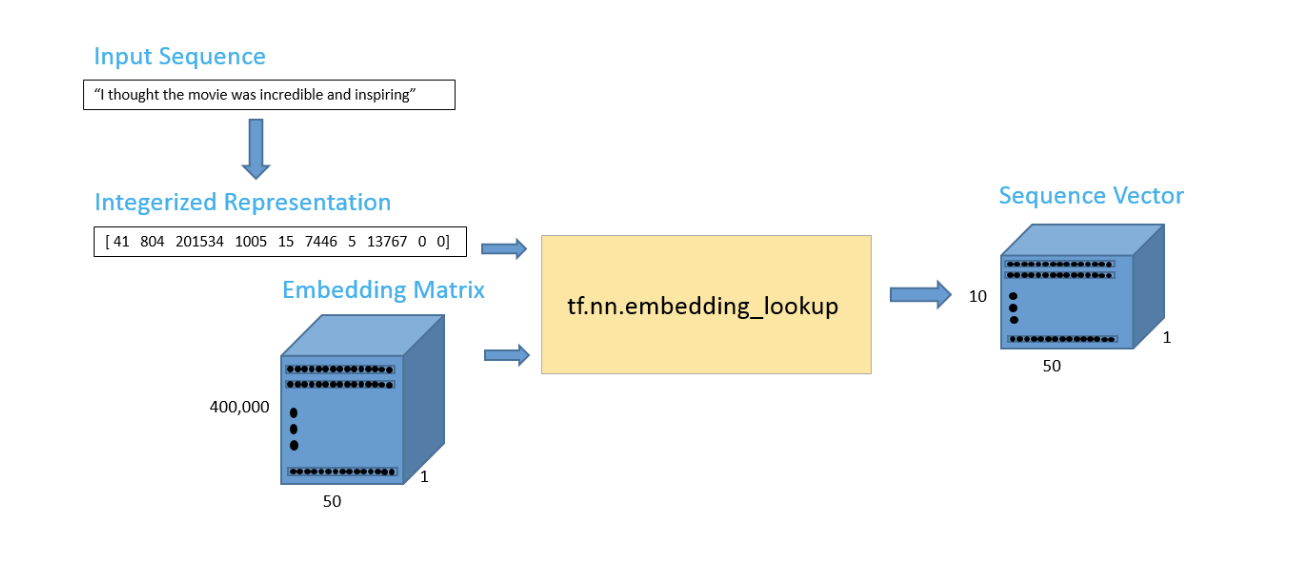

In [11]:
from IPython.display import Image
Image(filename='/home/ubuntu/rnn_lm.png') 

In [58]:
with tf.device("/cpu:0"):
    embedding = tf.get_variable("embeddingssssssssssSss", [vocab_size, embedding_size], dtype=data_type())
    inputs = tf.nn.embedding_lookup(embedding, train_data)
embedding_size
embedding.get_shape()

TensorShape([Dimension(10000), Dimension(128)])

In [56]:
# Regularization

if _is_training and config.keep_prob < 1:
    inputs = tf.nn.dropout(inputs, config.keep_prob)
inputs

<tf.Tensor 'embedding_lookup_8:0' shape=(929589, 20) dtype=float32>

In [14]:
config.rnn_mode

'basic'

In [15]:

if config.rnn_mode == BASIC:
    tf.contrib.rnn.BasicLSTMCell(
          config.hidden_size, forget_bias=0.0, state_is_tuple=True,
          reuse=not True)
elif config.rnn_mode == BLOCK:
    tf.contrib.rnn.LSTMBlockCell(
          config.hidden_size, forget_bias=0.0)
else:
    raise ValueError("rnn_mode %s not supported" % config.rnn_mode)

In [16]:
def _build_rnn_graph_lstm(self, inputs, config):
        """Build the inference graph using canonical LSTM cells."""
        # Slightly better results can be obtained with forget gate biases
        # initialized to 1 but the hyperparameters of the model would need to be
        # different than reported in the paper.
        cell = tf.contrib.rnn.BasicLSTMCell(config.hidden_size, forget_bias=0.0, state_is_tuple=True,reuse=not True)
        if True and config.keep_prob < 1:
            cell = tf.contrib.rnn.DropoutWrapper(
              cell, output_keep_prob=config.keep_prob)

        cell = tf.contrib.rnn.MultiRNNCell(
            [cell for _ in range(config.num_layers)], state_is_tuple=True)

        self._initial_state = cell.zero_state(config.batch_size, data_type())
        state = self._initial_state
        # Simplified version of tensorflow_models/tutorials/rnn/rnn.py's rnn().
        # This builds an unrolled LSTM for tutorial purposes only.
        # In general, use the rnn() or state_saving_rnn() from rnn.py.
        #
        # The alternative version of the code below is:
        #
        # inputs = tf.unstack(inputs, num=num_steps, axis=1)
        # outputs, state = tf.contrib.rnn.static_rnn(cell, inputs,
        #                            initial_state=self._initial_state)
        outputs = []
        with tf.variable_scope("RNN"):
            for time_step in range(self.num_steps):
                if time_step > 0: 
                    tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(inputs[:, time_step, :], state)
            outputs.append(cell_output)
            output = tf.reshape(tf.concat(outputs, 1), [-1, config.hidden_size])
        return output, state

In [17]:
config = get_config()
config

In [22]:
class PTBModel(object):
    """The PTB model."""
    def __init__(self, is_training, config, input_):
        self._is_training = is_training
        self._input = input_
        self._rnn_params = None
        self._cell = None
        self.batch_size = input_.batch_size
        self.num_steps = input_.num_steps
        size = config.hidden_size
        vocab_size = config.vocab_size

        with tf.device("/cpu:0"):
            embedding = tf.get_variable(
              "embeddingssss", [vocab_size, size], dtype=data_type())
            inputs = tf.nn.embedding_lookup(embedding, input_.input_data)

        if is_training and config.keep_prob < 1:
            inputs = tf.nn.dropout(inputs, config.keep_prob)
        output, state = self._build_rnn_graph(inputs, config, is_training)
        print("Output is:",output)
        
        softmax_w = tf.get_variable("softmax_w", [size, vocab_size], dtype=data_type())
        softmax_b = tf.get_variable("softmax_b", [vocab_size], dtype=data_type())
        
        print("Softmax w:", softmax_w)
        print("Softmax b:", softmax_b)
        
        logits = tf.nn.xw_plus_b(output, softmax_w, softmax_b)
        print(logits)
        logits = tf.reshape(logits, [self.batch_size, self.num_steps, vocab_size])
        print(logits)

        
        # Use the contrib sequence loss and average over the batches
        loss = tf.contrib.seq2seq.sequence_loss(
            logits,
            input_.targets,
            tf.ones([self.batch_size, self.num_steps], dtype=data_type()),
            average_across_timesteps=False,
            average_across_batch=True)
        print(loss)

    def _build_rnn_graph(self, inputs, config, is_training):
        if config.rnn_mode == CUDNN:
              return self._build_rnn_graph_cudnn(inputs, config, is_training)
        else:
              return self._build_rnn_graph_lstm(inputs, config, is_training)
            
    def _get_lstm_cell(self, config, is_training):
        if config.rnn_mode == BASIC:
            return tf.contrib.rnn.BasicLSTMCell(
              config.hidden_size, forget_bias=0.0, state_is_tuple=True,
              reuse=not is_training)
        if config.rnn_mode == BLOCK:
            return tf.contrib.rnn.LSTMBlockCell(
              config.hidden_size, forget_bias=0.0)
        raise ValueError("rnn_mode %s not supported" % config.rnn_mode)

    def _build_rnn_graph_lstm(self, inputs, config, is_training):
        """Build the inference graph using canonical LSTM cells."""
        # Slightly better results can be obtained with forget gate biases
        # initialized to 1 but the hyperparameters of the model would need to be
        # different than reported in the paper.
        cell = self._get_lstm_cell(config, is_training)
        if is_training and config.keep_prob < 1:
            cell = tf.contrib.rnn.DropoutWrapper(
              cell, output_keep_prob=config.keep_prob)

        cell = tf.contrib.rnn.MultiRNNCell(
            [cell for _ in range(config.num_layers)], state_is_tuple=True)

        self._initial_state = cell.zero_state(config.batch_size, data_type())
        state = self._initial_state
        # Simplified version of tensorflow_models/tutorials/rnn/rnn.py's rnn().
        # This builds an unrolled LSTM for tutorial purposes only.
        # In general, use the rnn() or state_saving_rnn() from rnn.py.
        #
        # The alternative version of the code below is:
        #
        # inputs = tf.unstack(inputs, num=num_steps, axis=1)
        # outputs, state = tf.contrib.rnn.static_rnn(cell, inputs,
        #                            initial_state=self._initial_state)
        outputs = []
        with tf.variable_scope("RNN"):
            for time_step in range(self.num_steps):
                if time_step > 0: 
                    tf.get_variable_scope().reuse_variables()
        (cell_output, state) = cell(inputs[:, time_step, :], state)
        outputs.append(cell_output)
        output = tf.reshape(tf.concat(outputs, 1), [-1, config.hidden_size])
        return output, state


In [23]:
with tf.name_scope("Train"):
    train_input = PTBInput(config=config, data=train_data, name="TrainInput")
    with tf.variable_scope("Model", reuse=tf.AUTO_REUSE, initializer=initializer):
        m = PTBModel(is_training=True, config=config, input_=train_input)


Output is: Tensor("Train_2/Model/Reshape:0", shape=(20, 20), dtype=float32)
Softmax w: <tf.Variable 'Model/softmax_w:0' shape=(20, 10000) dtype=float32_ref>
Softmax b: <tf.Variable 'Model/softmax_b:0' shape=(10000,) dtype=float32_ref>
Tensor("Train_2/Model/xw_plus_b:0", shape=(20, 10000), dtype=float32)


ValueError: Cannot reshape a tensor with 200000 elements to shape [20,20,10000] (4000000 elements) for 'Train_2/Model/Reshape_1' (op: 'Reshape') with input shapes: [20,10000], [3] and with input tensors computed as partial shapes: input[1] = [20,20,10000].

In [ ]:
from IPython.display import Image
Image(filename='/home/ubuntu/softmax.png') 